In [18]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt

In [19]:
colnames = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','num']
df_data = pd.read_csv('processed.cleveland.data',names=colnames, header=None)


In [20]:

df_data['num'] = df_data['num'].map(lambda x: 1 if x >= 1 else 0)


In [21]:

df_data.loc[df_data['cp'] == '?','cp'] = stats.mode(pd.to_numeric(df_data['cp'].loc[df_data['cp'] != '?']))[0]
df_data.loc[df_data['thal'] == '?','thal'] = stats.mode(pd.to_numeric(df_data['thal'].loc[df_data['thal'] != '?']))[0]
df_data['thal'] = pd.to_numeric(df_data['thal'])
df_data.loc[df_data['ca'] == '?','ca'] = stats.mode(pd.to_numeric(df_data['ca'].loc[df_data['ca'] != '?']))[0]
df_data['ca'] = pd.to_numeric(df_data['ca'])


In [22]:

df_data = pd.get_dummies(df_data,columns=['sex','cp','fbs','restecg','exang','slope','thal'],dtype=np.float64)

In [23]:
train_X,test_X,train_y,test_y = train_test_split(df_data.drop(['num'],axis=1),df_data['num'],shuffle=True, test_size=0.2, stratify=df_data['num'],random_state=1234)


In [24]:

df_train = train_X.join(train_y)
df_test = test_X.join(test_y)



Mean vectors of two classes (eqn 4.21 Bishop)

$$\textbf{m}_1 = \frac{1}{N_1}\sum_{n \in C_1}\textbf{x}_n, \qquad \textbf{m}_2 = \frac{1}{N_2}\sum_{n \in C_2}\textbf{x}_n$$

In [25]:
m1 = np.expand_dims(np.mean(df_train.loc[df_train['num'] == 0].drop(['num'],axis=1),axis=0),1)
m2 = np.expand_dims(np.mean(df_train.loc[df_train['num'] == 1].drop(['num'],axis=1),axis=0),1)

Within class covariance matrix (eqn 4.28 Bishop)
$$
\textbf{S}_W = \sum_{n \in C_1}(\textbf{x}_n - \textbf{m}_1)(\textbf{x}_n - \textbf{m}_1)^T + \sum_{n \in C_2}(\textbf{x}_n - \textbf{m}_2)(\textbf{x}_n - \textbf{m}_2)^T
$$

In [26]:
df_train_X_C1 = df_train.loc[df_train['num'] == 0,:].drop(['num'],axis=1)
df_train_X_C2 = df_train.loc[df_train['num'] == 1,:].drop(['num'],axis=1)

sw = np.dot((df_train_X_C1 - m1.T).T,(df_train_X_C1 - m1.T)) + np.dot((df_train_X_C2 - m2.T).T,(df_train_X_C2 - m2.T))


w is obtained using (Eqn 4.30 Bishop)
$$
\textbf{w} \propto \textbf{S}_W^{-1}(\textbf{m}_2 - \textbf{m}_1)

In [27]:
w = np.dot(np.linalg.inv(sw),(m2 - m1))

Utilizing the fact that the Fisher criterion is a special case of least squares approach to linear discrimination (section 4.1.5 Bishop) we can say that a vector x should be classified as class C1 if $y(x) = w^T(x - m)$ is > 0 and C2 otherwise, where m is the mean vector for the entire training dataset

In [28]:
m = np.expand_dims(np.mean(df_train.drop(['num'],axis=1),axis=0),1)

test_y_hats = np.dot((test_X - m.T),w)
test_y_predictions = (test_y_hats > 0).astype(np.int32)


In [29]:
print(accuracy_score(test_y_predictions,test_y))

0.8032786885245902


[]

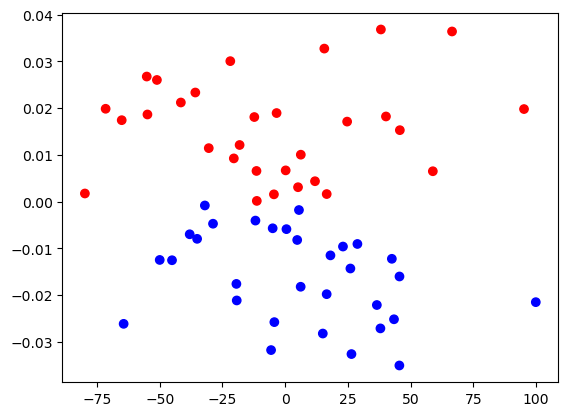

In [30]:
from sklearn.decomposition import PCA
x_pc_1 = PCA(n_components=1,random_state=1234).fit_transform(test_X)
x_pc_1.shape
fig,ax  = plt.subplots(nrows=1,ncols = 1)
ax.scatter(x = x_pc_1, y = test_y_hats, c = ['r' if itm == 1 else 'b' for itm in test_y_predictions])
plt.plot()

$$-\sum_{n=1}^{N}\{t_nlny_n + (1 - t_n)ln(1 - y_n)\}$$

$$\\$$
